In [1]:
import pickle  # Used for serializing and deserializing 
import keras  # Deep learning library for building and training neural networks
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for handling structured data
import os  # Provides functions for interacting with the operating system

from keras.layers import Dropout, MaxPooling1D, Reshape, multiply, Conv1D, GlobalAveragePooling1D, Dense
# Dropout - Prevents overfitting by randomly dropping neurons during training
# MaxPooling1D - Down-samples input by taking the max value in a given window
# Reshape - Reshapes input tensors into a specified shape
# multiply - Performs element-wise multiplication
# Conv1D - 1D convolutional layer used for feature extraction from sequential data
# GlobalAveragePooling1D - Reduces feature maps by computing the average over time steps
# Dense - Fully connected layer in the neural network

# Importing Keras utilities for model creation
from keras import Input, Model  

from keras.models import load_model  # Loads a pre-trained Keras model from a saved file

from keras.regularizers import l2  # L2 regularization to prevent overfitting by adding weight penalties

# Callbacks for training optimization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler  
# ModelCheckpoint - Saves the best model during training based on validation performance
# LearningRateScheduler - Adjusts learning rate dynamically during training

from scipy.interpolate import splev, splrep  
# splev - Evaluates a B-spline function
# splrep - Computes B-spline representation of data for interpolation

from sklearn.metrics import confusion_matrix, f1_score  
import random  # Used for generating random numbers

In [2]:
base_dir = "./dataset"  # Path to the dataset directory
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  
# Specifies which GPUs to use (e.g., GPU 0 and GPU 1).
ir = 3  # Interpolation interval (used for resampling or smoothing data)
before = 2  # Number of time steps to consider before an event (context window)
after = 2  # Number of time steps to consider after an event (context window)

In [3]:
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))  
# A lambda function to normalize an array to a range of [0, 1].
# It scales values using Min-Max normalization:
# - Subtracts the minimum value from all elements.
# - Divides by the range (max - min), ensuring values are between 0 and 1.
# This is useful for neural networks to improve convergence and stability during training.

In [4]:
def lr_schedule(epoch, lr):
    # Learning rate scheduler function to adjust the learning rate dynamically during training.
    
    if epoch > 70 and (epoch - 1) % 10 == 0:
        # If the epoch number is greater than 70 and is a multiple of 10 (starting from 71),
        # reduce the learning rate by a factor of 0.1.
        lr *= 0.1  

    return lr  # Return the updated learning rate

In [5]:
def load_data(path):
    # Generate time values for interpolation
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))  
    # 'tm' is an array of time points for interpolation
    # It spans (before + 1 + after) minutes with steps of (1 / ir) seconds.

    # Load the dataset using pickle
    with open(os.path.join(base_dir, path), 'rb') as f:
        apnea_ecg = pickle.load(f)  # Load the preprocessed data dictionary

    # Initialize empty lists for feature storage
    x_train1, x_train2, x_train3 = [], [], []  
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]  # Extract training features and labels
    groups_train = apnea_ecg["groups_train"]  # Extract subject grouping information

    # Data Interpolation Process
    for i in range(len(o_train)):  # Loop through all training samples
        (rri_tm, rri_signal), (ampl_tm, ampl_signal) = o_train[i]  # Extract RR interval and amplitude data
        
        # Apply cubic spline interpolation to normalize and smooth the signals
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_signal), k=3), ext=1)

        # Store full and segmented interpolated signals
        x_train1.append([rri_interp_signal, ampl_interp_signal])  # Full signal
        x_train2.append([rri_interp_signal[180:720], ampl_interp_signal[180:720]])  # Middle segment
        x_train3.append([rri_interp_signal[360:540], ampl_interp_signal[360:540]])  # Center segment

    # Split dataset into training (80%) and validation (20%) sets
    trainlist = random.sample(range(len(o_train)), int(len(o_train) * 0.8))  # Select 80% indices randomly
    vallist = list(set(range(len(o_train))) - set(trainlist))  # Remaining 20% for validation

    # Initialize lists for training and validation sets
    x_training1, x_training2, x_training3, y_training, groups_training = [], [], [], [], []
    x_val1, x_val2, x_val3, y_val, groups_val = [], [], [], [], []

    # Assign training data based on selected indices
    for i in trainlist:
        x_training1.append(x_train1[i])
        x_training2.append(x_train2[i])
        x_training3.append(x_train3[i])
        y_training.append(y_train[i])
        groups_training.append(groups_train[i])

    # Assign validation data based on selected indices
    for i in vallist:
        x_val1.append(x_train1[i])
        x_val2.append(x_train2[i])
        x_val3.append(x_train3[i])
        y_val.append(y_train[i])
        groups_val.append(groups_train[i])

    # Convert lists into NumPy arrays for model input
    def to_numpy(arr):
        return np.array(arr, dtype="float32").transpose((0, 2, 1))  # Transpose to match expected input shape

    x_training1, x_training2, x_training3 = map(to_numpy, [x_training1, x_training2, x_training3])
    x_val1, x_val2, x_val3 = map(to_numpy, [x_val1, x_val2, x_val3])
    y_training, y_val = np.array(y_training, dtype="float32"), np.array(y_val, dtype="float32")

    # Processing test data
    x_test1, x_test2, x_test3 = [], [], []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]  # Extract test features and labels
    groups_test = apnea_ecg["groups_test"]  # Extract subject grouping for test set

    for i in range(len(o_test)):  # Loop through all test samples
        (rri_tm, rri_signal), (ampl_tm, ampl_signal) = o_test[i]  # Extract RR interval and amplitude data

        # Apply interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_signal), k=3), ext=1)

        # Store interpolated data
        x_test1.append([rri_interp_signal, ampl_interp_signal])  # Full signal
        x_test2.append([rri_interp_signal[180:720], ampl_interp_signal[180:720]])  # Middle segment
        x_test3.append([rri_interp_signal[360:540], ampl_interp_signal[360:540]])  # Center segment

    # Convert test data to NumPy arrays
    x_test1, x_test2, x_test3 = map(to_numpy, [x_test1, x_test2, x_test3])
    y_test = np.array(y_test, dtype="float32")

    # Return processed training, validation, and test sets
    return x_training1, x_training2, x_training3, y_training, groups_training, \
           x_val1, x_val2, x_val3, y_val, groups_val, \
           x_test1, x_test2, x_test3, y_test, groups_test

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense,
                                     Reshape, Dropout, multiply, ZeroPadding1D, Bidirectional, LSTM,
                                     BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def create_model(input_a_shape, input_b_shape, input_c_shape, weight=1e-3):
    def cnn_block(input_shape, target_length=30):  
        """CNN Feature Extraction Block with Batch Normalization and Zero Padding"""
        
        # Define input layer
        input_layer = Input(shape=input_shape)

        # Zero-padding if input length is shorter than target length
        pad_size = max(0, target_length - input_shape[0])
        x = ZeroPadding1D(padding=(0, pad_size))(input_layer) if pad_size > 0 else input_layer

        # Convolutional layers with Batch Normalization and ReLU activation
        x = Conv1D(16, kernel_size=11, strides=1, padding="same", activation=None,
                   kernel_regularizer=l2(weight))(x)
        x = BatchNormalization()(x)  
        x = tf.keras.activations.relu(x)  # Activation after BatchNorm

        x = Conv1D(24, kernel_size=11, strides=2, padding="same", activation=None,
                   kernel_regularizer=l2(weight))(x)
        x = BatchNormalization()(x)  
        x = tf.keras.activations.relu(x)

        # MaxPooling to reduce dimensionality
        x = MaxPooling1D(pool_size=3, padding="same")(x)

        x = Conv1D(32, kernel_size=11, strides=1, padding="same", activation=None,
                   kernel_regularizer=l2(weight))(x)
        x = BatchNormalization()(x)  
        x = tf.keras.activations.relu(x)

        x = MaxPooling1D(pool_size=5, padding="same")(x)

        return input_layer, x  # Return input layer and CNN output

    # Determine the target length to apply padding if needed
    target_length = max(input_a_shape[0], input_b_shape[0], input_c_shape[0])

    # Apply CNN block to all three input signals
    input1, x1 = cnn_block(input_a_shape, target_length)
    input2, x2 = cnn_block(input_b_shape, target_length)
    input3, x3 = cnn_block(input_c_shape, target_length)

    # Concatenate extracted CNN features from all three inputs
    concat = tf.keras.layers.Concatenate(name="Concat_Layer", axis=-1)([x1, x2, x3])

    # BiLSTM for sequential feature learning
    bilstm_out = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.2))(concat)

    # Squeeze-and-Excitation Block for adaptive feature recalibration
    squeeze = GlobalAveragePooling1D()(bilstm_out)  # Global feature extraction
    excitation = Dense(128, activation='relu')(squeeze)  # Fully connected layer with ReLU
    excitation = Dense(128, activation='sigmoid')(excitation)  # Sigmoid activation for attention scaling
    excitation = Reshape((1, 128))(excitation)  # Reshape to match BiLSTM output shape

    # Multiply BiLSTM output with excitation weights
    scale = multiply([bilstm_out, excitation])

    # Final Classification Layers
    x = GlobalAveragePooling1D()(scale)  # Global feature aggregation
    dp = Dropout(0.5)(x)  # Dropout for regularization
    outputs = Dense(2, activation='softmax', name="Output_Layer")(dp)  # Softmax for binary classification

    # Return the compiled model
    return Model(inputs=[input1, input2, input3], outputs=outputs)

Epoch 1/100
209/209 - 43s - 207ms/step - accuracy: 0.7783 - loss: 0.5473 - val_accuracy: 0.5003 - val_loss: 0.9304 - learning_rate: 0.0010
Epoch 2/100
209/209 - 30s - 142ms/step - accuracy: 0.8733 - loss: 0.3693 - val_accuracy: 0.8776 - val_loss: 0.3510 - learning_rate: 0.0010
Epoch 3/100
209/209 - 29s - 139ms/step - accuracy: 0.8899 - loss: 0.3233 - val_accuracy: 0.8782 - val_loss: 0.3500 - learning_rate: 0.0010
Epoch 4/100
209/209 - 33s - 156ms/step - accuracy: 0.8942 - loss: 0.3012 - val_accuracy: 0.8983 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 5/100
209/209 - 35s - 168ms/step - accuracy: 0.8997 - loss: 0.2849 - val_accuracy: 0.9025 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 6/100
209/209 - 30s - 145ms/step - accuracy: 0.9066 - loss: 0.2690 - val_accuracy: 0.9025 - val_loss: 0.2890 - learning_rate: 0.0010
Epoch 7/100
209/209 - 41s - 196ms/step - accuracy: 0.9082 - loss: 0.2674 - val_accuracy: 0.9135 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 8/100
209/209 - 30s -

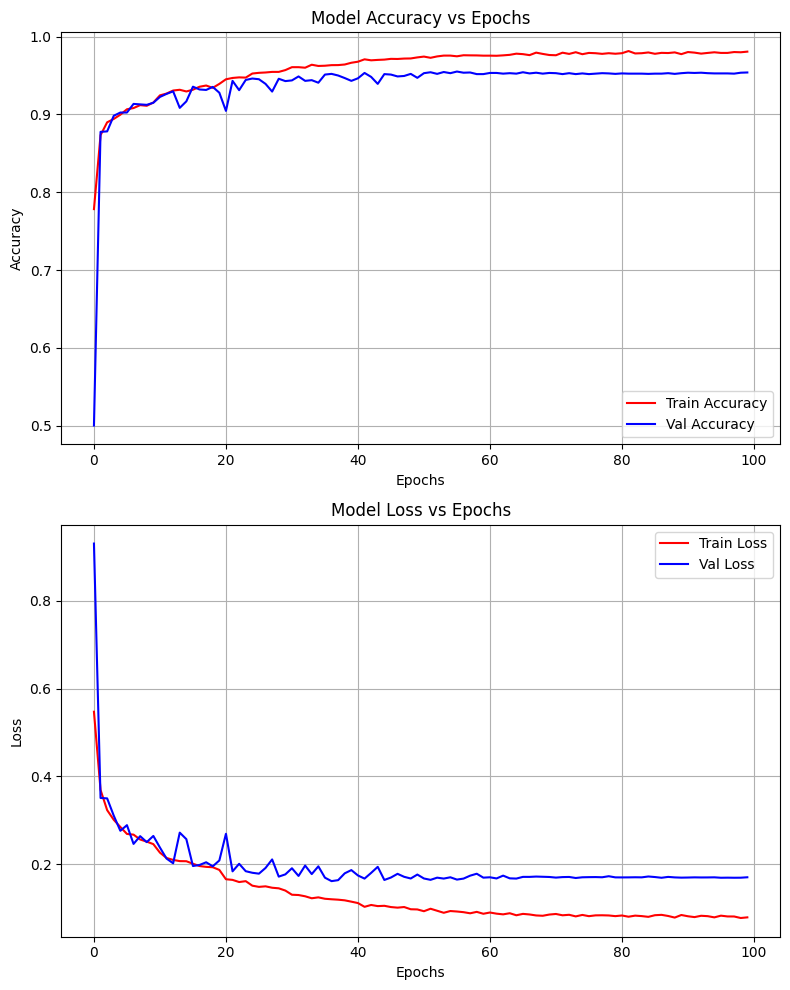

Test Accuracy: 0.8990


In [ ]:
import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import tensorflow as tf

def customizeAdam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
    """
    Creates a customized Adam optimizer with specified parameters.
    """
    return tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

# Learning Rate Schedule Function
def lr_schedule(epoch, lr):
    """
    Adjusts the learning rate every 10 epochs by halving it.
    """
    return 0.001 * (0.5 ** (epoch // 10))

# Function to Plot Training Accuracy and Loss
def plot_training_history(history):
    """
    Plots accuracy and loss curves for training and validation.
    """
    plt.figure(figsize=(8, 10))  # Set figure size

    # Accuracy Plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], color='blue', label='Val Accuracy')
    plt.title('Model Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss Plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], color='red', label='Train Loss')
    plt.plot(history.history['val_loss'], color='blue', label='Val Loss')
    plt.title('Model Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Main function for model training and evaluation
def main():
    path = "apnea-ecg.pkl"  # Path to dataset

    # Load preprocessed data
    x_train1, x_train2, x_train3, y_train, _, x_val1, x_val2, x_val3, y_val, _, x_test1, x_test2, x_test3, y_test, _ = load_data(path)

    # Convert labels to categorical format for binary classification (0/1 to [1,0] or [0,1])
    y_train = keras.utils.to_categorical(y_train, num_classes=2)
    y_val = keras.utils.to_categorical(y_val, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    # Create model using input shapes from training data
    model = create_model(x_train1.shape[1:], x_train2.shape[1:], x_train3.shape[1:])
    
    # Compile model with customized Adam optimizer
    model.compile(loss='binary_crossentropy', 
                  optimizer=customizeAdam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
                  metrics=['accuracy'])

    # Define callbacks:
    # - ModelCheckpoint: Save the best model based on validation accuracy
    # - LearningRateScheduler: Adjust learning rate dynamically
    checkpoint = ModelCheckpoint('weights.best.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

    # Train the model
    history = model.fit(
        [x_train1, x_train2, x_train3], y_train, 
        batch_size=64, epochs=100, 
        validation_data=([x_val1, x_val2, x_val3], y_val), 
        callbacks=[checkpoint, lr_scheduler], 
        verbose=2  # Print training progress
    )
    # Plot accuracy and loss graphs
    plot_training_history(history)

    # Load best model and evaluate on test data
    model = load_model('weights.best.keras')
    loss, accuracy = model.evaluate([x_test1, x_test2, x_test3], y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

# Run the script
if __name__ == "__main__":
    main()

530/530 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step


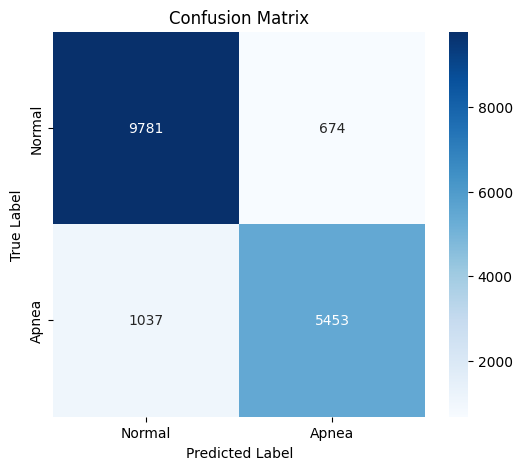

Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.94      0.92     10455
       Apnea       0.89      0.84      0.86      6490

    accuracy                           0.90     16945
   macro avg       0.90      0.89      0.89     16945
weighted avg       0.90      0.90      0.90     16945



In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names=['Normal', 'Apnea']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Load dataset BEFORE loading the model
path = "apnea-ecg.pkl"  # Ensure the correct path
x_train1, x_train2, x_train3, y_train, _, x_val1, x_val2, x_val3, y_val, _, x_test1, x_test2, x_test3, y_test, _ = load_data(path)

# Check if y_test is already 1D
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)  # Convert from one-hot encoding if needed

# Load best model
model = load_model('weights.best.keras')

# Make predictions on test data
y_pred_prob = model.predict([x_test1, x_test2, x_test3])
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Apnea']))

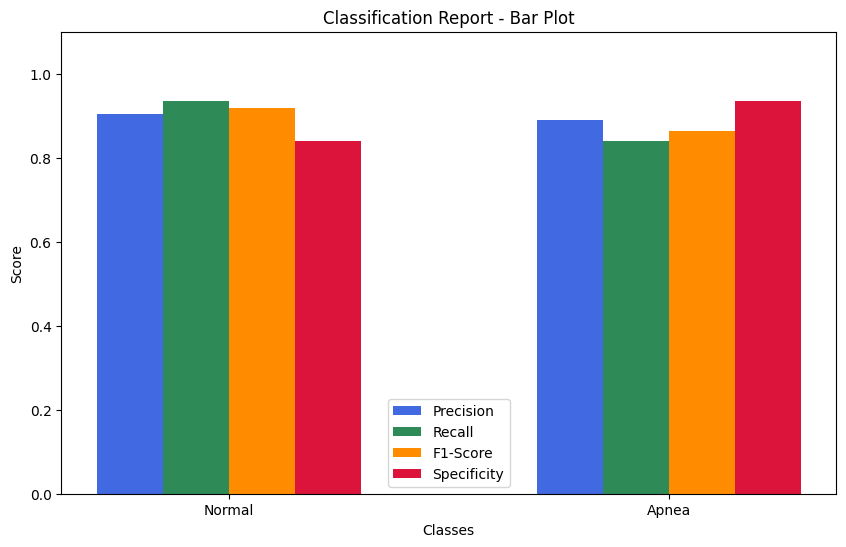

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot classification report including specificity
def plot_classification_report_bar(y_true, y_pred, class_names=['Normal', 'Apnea']):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate Specificity for each class
    specificity = []
    for i in range(len(class_names)):
        tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Extract Precision, Recall, F1-Score
    metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
    values = np.array([
        [report[label]['precision'], report[label]['recall'], report[label]['f1-score'], specificity[i]] 
        for i, label in enumerate(class_names)
    ])

    # Colors for each metric
    colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']

    # Plot settings
    x = np.arange(len(class_names))  # Label positions
    width = 0.15  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bar plots for each metric with different colors
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        ax.bar(x + i * width, values[:, i], width, label=metric, color=color)

    # Labeling
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(class_names)
    ax.set_ylim(0, 1.1)  # Limit from 0 to 1
    ax.set_xlabel("Classes")
    ax.set_ylabel("Score")
    ax.set_title("Classification Report - Bar Plot")
    ax.legend()

    plt.show()

# Example Usage
plot_classification_report_bar(y_test, y_pred)

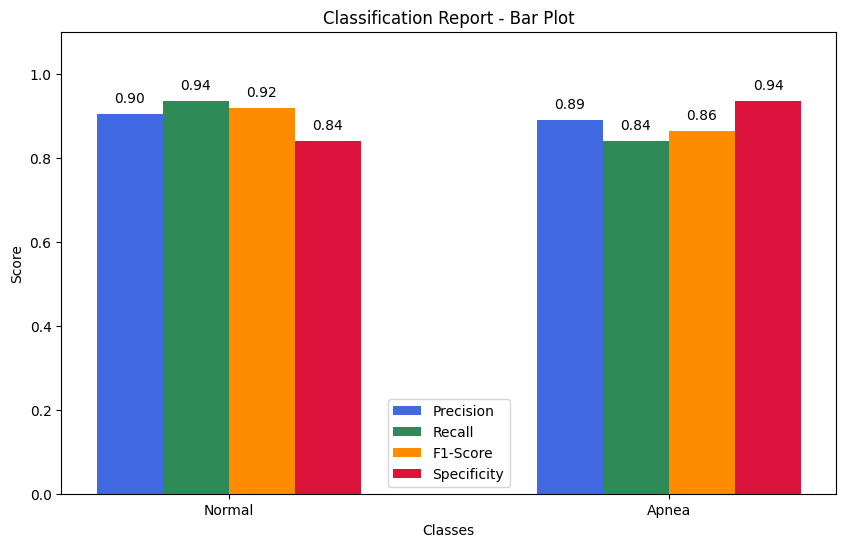

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot classification report including specificity with values on top
def plot_classification_report_bar(y_true, y_pred, class_names=['Normal', 'Apnea']):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate Specificity for each class
    specificity = []
    for i in range(len(class_names)):
        tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Extract Precision, Recall, F1-Score
    metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
    values = np.array([
        [report[label]['precision'], report[label]['recall'], report[label]['f1-score'], specificity[i]] 
        for i, label in enumerate(class_names)
    ])

    # Colors for each metric
    colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']

    # Plot settings
    x = np.arange(len(class_names))  # Label positions
    width = 0.15  # Bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bar plots for each metric with different colors
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        bars = ax.bar(x + i * width, values[:, i], width, label=metric, color=color)
        
        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.2f}', 
                    ha='center', va='bottom', fontsize=10)

    # Labeling
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(class_names)
    ax.set_ylim(0, 1.1)  # Limit from 0 to 1
    ax.set_xlabel("Classes")
    ax.set_ylabel("Score")
    ax.set_title("Classification Report - Bar Plot")
    ax.legend()

    plt.show()

# Example Usage
plot_classification_report_bar(y_test, y_pred)

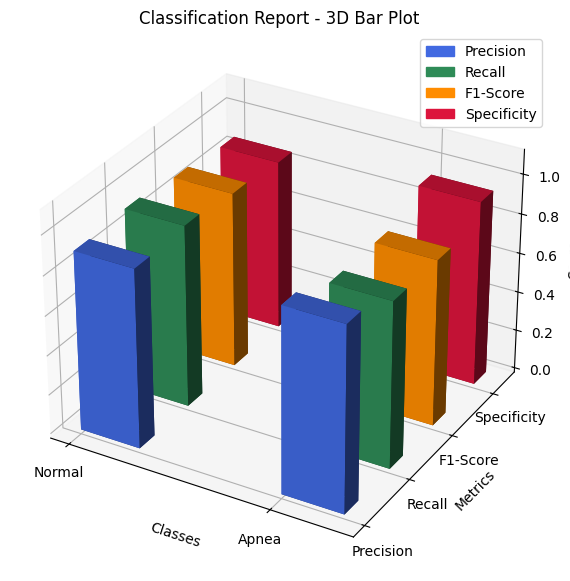

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

# Function to plot Classification Report in 3D with same color for each metric
def plot_classification_report_3d(y_true, y_pred, class_names=['Normal', 'Apnea']):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate Specificity for each class
    specificity = []
    for i in range(len(class_names)):
        tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Extract Precision, Recall, F1-Score, and Specificity
    metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
    values = np.array([
        [report[label]['precision'], report[label]['recall'], report[label]['f1-score'], specificity[i]] 
        for i, label in enumerate(class_names)
    ])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    x_pos = np.arange(len(class_names))  # X positions (classes)
    y_pos = np.arange(len(metrics))  # Y positions (metrics)
    x_pos, y_pos = np.meshgrid(x_pos, y_pos)
    x_pos = x_pos.flatten()
    y_pos = y_pos.flatten()
    z_pos = np.zeros_like(x_pos)  # Base of bars

    dx = dy = 0.3  # Width of bars
    dz = values.flatten()  # Heights of bars

    # Define colors for each metric (same color across all classes)
    metric_colors = {
        'Precision': 'royalblue',
        'Recall': 'seagreen',
        'F1-Score': 'darkorange',
        'Specificity': 'crimson'
    }

    # Generate color mapping based on metric type
    bar_colors = [metric_colors[metrics[y]] for y in y_pos]

    ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=bar_colors, shade=True)

    # Set labels and ticks
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(len(metrics)))
    ax.set_yticklabels(metrics)
    ax.set_zlim(0, 1.1)  # Limit to range 0-1
    ax.set_xlabel("Classes")
    ax.set_ylabel("Metrics")
    ax.set_zlabel("Scores")
    ax.set_title("Classification Report - 3D Bar Plot")

    # Create a legend mapping colors to metrics
    legend_patches = [plt.Rectangle((0,0),1,1, color=color) for color in metric_colors.values()]
    ax.legend(legend_patches, metrics, loc='upper right')

    plt.show()

# Example Usage
plot_classification_report_3d(y_test, y_pred)

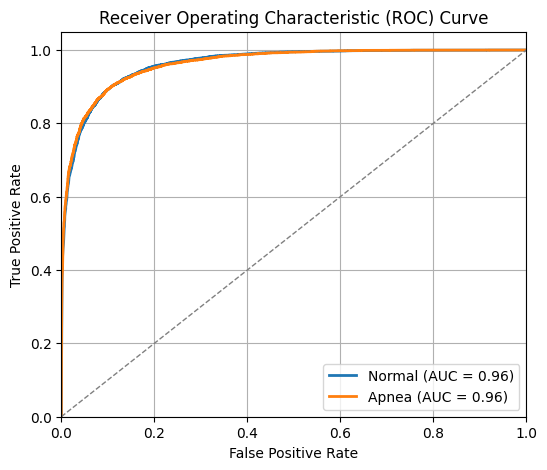

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC Curves for both classes
def plot_roc_curve(y_true, y_pred_prob, class_names=['Normal', 'Apnea']):
    plt.figure(figsize=(6, 5))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])  # ROC for each class
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    # Reference line for random classifier
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

    # Labels and Title
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Example usage
plot_roc_curve(y_test, y_pred_prob)

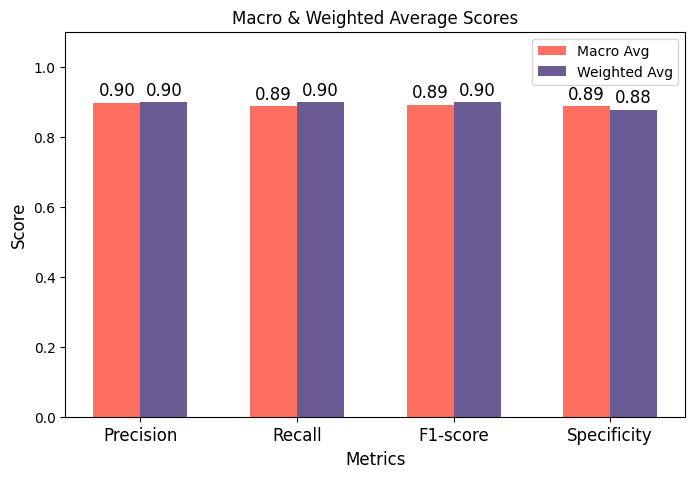

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot Macro & Weighted Averages (Including Specificity)
def plot_macro_weighted(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Calculate specificity for each class
    specificity_scores = []
    for i in range(len(cm)):
        tn = np.sum(cm) - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity_scores.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Compute Macro & Weighted Averages for Specificity
    macro_specificity = np.mean(specificity_scores)
    weighted_specificity = np.sum([specificity_scores[i] * sum(cm[i, :]) for i in range(len(cm))]) / np.sum(cm)

    # Metrics and values
    metrics = ["Precision", "Recall", "F1-score", "Specificity"]
    macro_values = [report["macro avg"][metric.lower()] for metric in metrics[:-1]] + [macro_specificity]
    weighted_values = [report["weighted avg"][metric.lower()] for metric in metrics[:-1]] + [weighted_specificity]

    x = np.arange(len(metrics))  # Label positions
    width = 0.3  # Bar width

    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Bar plots for macro and weighted averages
    bars1 = ax.bar(x - width/2, macro_values, width, label="Macro Avg", color='#FF6F61')  # Coral
    bars2 = ax.bar(x + width/2, weighted_values, width, label="Weighted Avg", color='#6B5B95')  # Purple

    # Add value labels on top of bars
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=12, color='black')

    # Labels & Titles
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylim(0, 1.1)  # Limit from 0 to 1
    ax.set_xlabel("Metrics", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_title("Macro & Weighted Average Scores")
    ax.legend()

    plt.show()

# Example Usage
plot_macro_weighted(y_test, y_pred)
